In [4]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np

import time

In [5]:
import sys
sys.path += ["../../../particleflow/mlpf/"]
from tfmodel.model_setup import make_model
from tfmodel.utils import parse_config

import tensorflow as tf
import tensorflow_datasets as tfds

import pathlib

2024-02-01 07:31:15.469767: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-01 07:31:15.656997: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-01 07:31:15.657021: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-01 07:31:15.658026: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-01 07:31:15.731360: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-01 07:31:15.732768: I tensorflow/core/platform/cpu_feature_guard.cc:182] This Tens

In [6]:
ds_builder = tfds.builder("clic_edm_qq_pf", data_dir = '../../tensorflow_datasets/') # Tensorflow datsets positions in the lxplus
dss = ds_builder.as_data_source("test")

In [7]:
def yield_from_ds():
    for elem in dss:
        yield {"X": elem["X"], "ygen": elem["ygen"], "ycand": elem["ycand"]}

In [8]:
output_signature = {k: tf.TensorSpec(shape=(None, v.shape[1])) for (k, v) in dss.dataset_info.features.items()}
tf_dataset = tf.data.Dataset.from_generator(yield_from_ds, output_signature=output_signature).take(100).padded_batch(batch_size=10)

In [9]:
output_signature

{'X': TensorSpec(shape=(None, 17), dtype=tf.float32, name=None),
 'ycand': TensorSpec(shape=(None, 8), dtype=tf.float32, name=None),
 'ygen': TensorSpec(shape=(None, 8), dtype=tf.float32, name=None)}

In [10]:
data = list(tfds.as_numpy(tf_dataset))

In [11]:
Xs = [d["X"] for d in data]
ys = [d["ygen"] for d in data]

In [12]:
ys[0][9][:,:4]

array([[ 1.        , -1.        ,  3.5555263 ,  0.22640967],
       [ 1.        , -1.        ,  2.4462407 ,  0.195159  ],
       [ 1.        ,  1.        ,  0.8356094 , -0.5446882 ],
       [ 1.        ,  1.        ,  0.85157084, -1.37132   ],
       [ 1.        ,  1.        ,  0.6311886 , -0.9460032 ],
       [ 1.        ,  1.        ,  0.560444  , -0.38950145],
       [ 1.        , -1.        ,  0.50040615, -0.29128084],
       [ 1.        , -1.        ,  0.40326795,  0.19255948],
       [ 1.        ,  1.        ,  0.37885737,  0.12188682],
       [ 1.        , -1.        ,  0.36663368, -2.1641972 ],
       [ 1.        ,  1.        ,  0.3846691 ,  0.68863004],
       [ 1.        ,  1.        ,  0.3615032 , -0.81029856],
       [ 1.        , -1.        ,  0.18166022,  0.15179   ],
       [ 1.        , -1.        ,  0.21182844,  1.8761586 ],
       [ 0.        ,  0.        ,  0.        ,  0.        ],
       [ 1.        , -1.        ,  0.16170818, -0.88895464],
       [ 1.        ,  1.

In [13]:
#batch 0, max 111 particles per event
Xs[0].shape

(10, 111, 17)

In [14]:
#batch 3 has 10 events, max 90 particles per event
Xs[3].shape

(10, 90, 17)

In [15]:
# Check the lengths of sublists in Xs
sublist_lengths = [len(sublist) for sublist in Xs]
print("Lengths of sublists in Xs:", sublist_lengths)


Lengths of sublists in Xs: [10, 10, 10, 10, 10, 10, 10, 10, 10, 10]


In [16]:
for X_q in Xs:
    print("Shape of X_q:", X_q.shape) 

Shape of X_q: (10, 111, 17)
Shape of X_q: (10, 186, 17)
Shape of X_q: (10, 142, 17)
Shape of X_q: (10, 90, 17)
Shape of X_q: (10, 111, 17)
Shape of X_q: (10, 195, 17)
Shape of X_q: (10, 100, 17)
Shape of X_q: (10, 81, 17)
Shape of X_q: (10, 130, 17)
Shape of X_q: (10, 147, 17)


In [17]:
for y_q in ys:
    print("Shape of yq:", y_q.shape)

Shape of yq: (10, 111, 8)
Shape of yq: (10, 186, 8)
Shape of yq: (10, 142, 8)
Shape of yq: (10, 90, 8)
Shape of yq: (10, 111, 8)
Shape of yq: (10, 195, 8)
Shape of yq: (10, 100, 8)
Shape of yq: (10, 81, 8)
Shape of yq: (10, 130, 8)
Shape of yq: (10, 147, 8)


## Quantizing the model
### post-training dynamic range quantization

Quantizing with post-training dynamic range quantization.
Using the TensorFlow Lite Converter, you can now convert the trained model into a TensorFlow Lite model.



In [18]:
config, _ = parse_config("../../../particleflow/parameters/clic.yaml") #positions on the lxplus
model = make_model(config, tf.float32)
Xdummy = np.zeros((1,256,17), dtype=np.float32)
model(Xdummy)
model.load_weights("weights-96-5.346523.hdf5", skip_mismatch=False, by_name=True)

In [19]:
def model_output(ret):
    return tf.concat(
        [
            ret["cls"], #0-5
            ret["charge"], #6-8
            ret["pt"], #9
            ret["eta"], #10
            ret["sin_phi"], #11
            ret["cos_phi"], #12
            ret["energy"], #13
        ],
        axis=-1,
    )

full_model = tf.function(lambda x: model_output(model(x, training=False)))

In [20]:
true_pts = []
pred_pts = []
#loop over batches
start_time = time.time()
for i in range(len(Xs)):
    ret = full_model(Xs[i])
    msk_true_part = ys[i][..., 0]!=0
    true_pts.append(ys[i][msk_true_part][..., 2])
    pred_pts.append(ret[msk_true_part][..., 9])
true_pts = np.hstack(true_pts)
pred_pts = np.hstack(pred_pts)
end_time = time.time()
inference_time_unquantized = end_time - start_time
print("Inference time for unquantized model:", inference_time_unquantized, "seconds")


Inference time for unquantized model: 21.163666248321533 seconds


Text(0, 0.5, 'predicted pt')

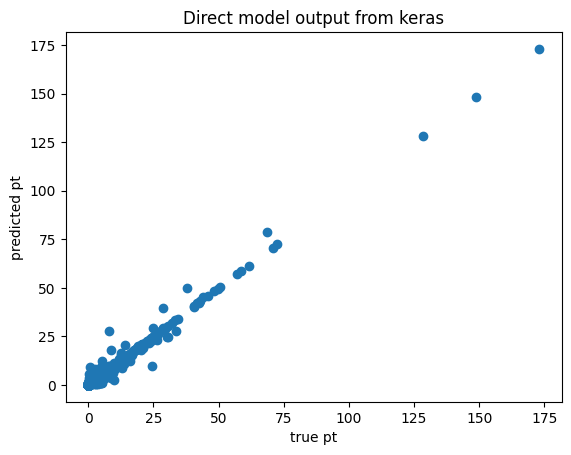

In [21]:
plt.title("Direct model output from keras")
plt.scatter(true_pts, pred_pts)
plt.xlabel("true pt")
plt.ylabel("predicted pt")

In [22]:
converter = tf.lite.TFLiteConverter.from_concrete_functions([full_model.get_concrete_function(Xdummy)])
tflite_model = converter.convert()

2024-02-01 07:31:43.660362: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0
2024-02-01 07:31:43.660471: I tensorflow/core/grappler/clusters/single_machine.cc:361] Starting new session
2024-02-01 07:31:46.689494: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-02-01 07:31:46.689522: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-02-01 07:31:47.261138: I tensorflow/compiler/mlir/lite/flatbuffer_export.cc:2245] Estimated count of arithmetic ops: 2.916 G  ops, equivalently 1.458 G  MACs


Write it out to a tflite file:



In [23]:
tflite_models_dir = pathlib.Path("/tmp/working1_tflite_models/")
tflite_models_dir.mkdir(exist_ok=True, parents=True)

In [24]:
tflite_model_file = tflite_models_dir/"working1_tflite_models.tflite"
tflite_model_file.write_bytes(tflite_model)

22468840

To quantize the model on export, set the optimizations flag to optimize for size:



In [25]:
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quant_model = converter.convert()
tflite_model_quant_file = tflite_models_dir/"working_model_quant.tflite"
tflite_model_quant_file.write_bytes(tflite_quant_model)


2024-02-01 07:31:48.307681: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0
2024-02-01 07:31:48.307774: I tensorflow/core/grappler/clusters/single_machine.cc:361] Starting new session
2024-02-01 07:31:50.826887: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-02-01 07:31:50.826913: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-02-01 07:31:52.206751: I tensorflow/compiler/mlir/lite/flatbuffer_export.cc:2245] Estimated count of arithmetic ops: 2.916 G  ops, equivalently 1.458 G  MACs


6126520

As expected the resulting file, is approximately 1/4 the size.



Run the TFLite models



Test the model on the quantized data: https://www.tensorflow.org/lite/performance/post_training_quant



In [26]:
start_time = time.time()

true_pts = []
pred_pts = []
pred_pts_quantized = []

interpreter = tf.lite.Interpreter(model_path=str(tflite_model_file))
interpreter.allocate_tensors()
input_index1 = interpreter.get_input_details()[0]["index"]
output_index1 = interpreter.get_output_details()[0]["index"]

interpreter_quant = tf.lite.Interpreter(model_path=str(tflite_model_quant_file))
interpreter_quant.allocate_tensors()
input_index2 = interpreter_quant.get_input_details()[0]["index"]
output_index2 = interpreter_quant.get_output_details()[0]["index"]

for ibatch in range(len(Xs)):
#for ibatch in range(5):
    for iev in range(len(Xs[ibatch])):

        this_X = tf.expand_dims(Xs[ibatch][iev], 0)
        pad_size = [[0,0],[0,Xdummy.shape[1]-this_X.shape[1]], [0,0]]
        this_X = tf.pad(this_X, pad_size)
        this_ys = tf.pad(ys[ibatch][iev], pad_size[1:])
        
        interpreter.set_tensor(input_index1, this_X)
        interpreter.invoke()
        
        interpreter_quant.set_tensor(input_index2, this_X)
        interpreter_quant.invoke()
        
        mask_true_particles = this_ys[..., 0] != 0
        true_pt = this_ys[mask_true_particles][..., 2]
        output1 = interpreter.tensor(output_index1)()[0][mask_true_particles][..., 9]
        output2 = interpreter_quant.tensor(output_index2)()[0][mask_true_particles][..., 9]
        
        true_pts.append(true_pt)
        pred_pts.append(output1)
        pred_pts_quantized.append(output2)
        
end_time = time.time()
inference_time_quantized = end_time - start_time
print("Inference time for quantized model:", inference_time_quantized, "seconds")

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


Inference time for quantized model: 23.2595112323761 seconds


In [27]:
interpreter.get_input_details()

[{'name': 'x',
  'index': 0,
  'shape': array([  1, 256,  17], dtype=int32),
  'shape_signature': array([  1, 256,  17], dtype=int32),
  'dtype': numpy.float32,
  'quantization': (0.0, 0),
  'quantization_parameters': {'scales': array([], dtype=float32),
   'zero_points': array([], dtype=int32),
   'quantized_dimension': 0},
  'sparsity_parameters': {}}]

In [28]:
interpreter.get_output_details()


[{'name': 'Identity',
  'index': 1546,
  'shape': array([  1, 256,  14], dtype=int32),
  'shape_signature': array([  1, 256,  14], dtype=int32),
  'dtype': numpy.float32,
  'quantization': (0.0, 0),
  'quantization_parameters': {'scales': array([], dtype=float32),
   'zero_points': array([], dtype=int32),
   'quantized_dimension': 0},
  'sparsity_parameters': {}}]

In [29]:
flat_true_pts = np.hstack(true_pts)
flat_pred_pts = np.hstack(pred_pts)
flat_pred_pts_quantized = np.hstack(pred_pts_quantized)

In [30]:
flat_true_pts.shape, flat_pred_pts.shape, flat_pred_pts_quantized.shape

((4250,), (4250,), (4250,))

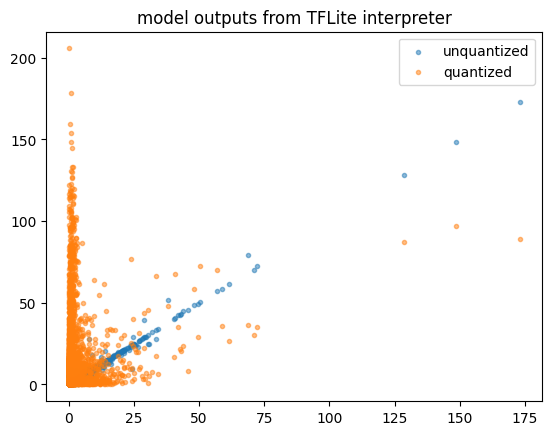

In [31]:
plt.title("model outputs from TFLite interpreter")
plt.scatter(flat_true_pts, flat_pred_pts, label="unquantized", marker=".", alpha=0.5)
plt.scatter(flat_true_pts, flat_pred_pts_quantized, label="quantized", marker=".", alpha=0.5)
plt.legend(loc="best")

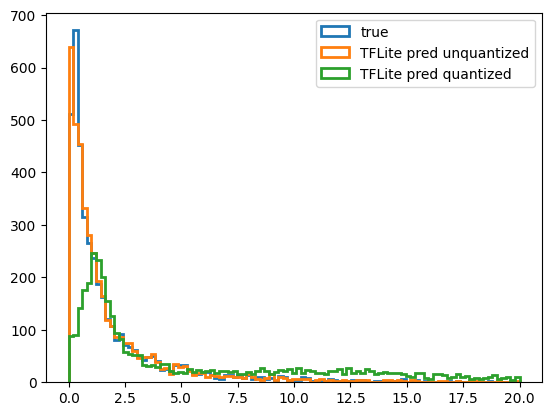

In [32]:
plt.hist(flat_true_pts, bins=np.linspace(0,20,100), histtype="step", label="true", lw=2);
plt.hist(flat_pred_pts, bins=np.linspace(0,20,100), histtype="step", label="TFLite pred unquantized", lw=2);
plt.hist(flat_pred_pts_quantized, bins=np.linspace(0,20,100), histtype="step", label="TFLite pred quantized", lw=2);
plt.legend(loc="best")

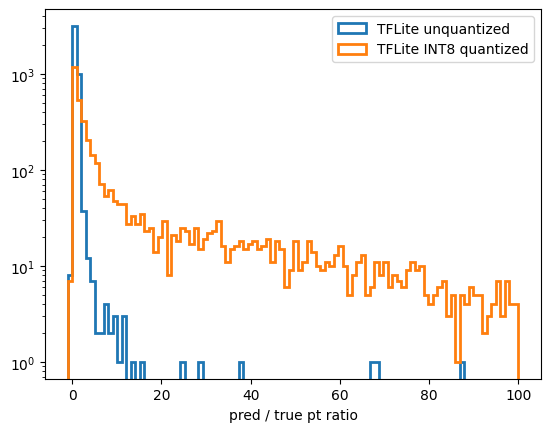

In [34]:
plt.hist(flat_pred_pts/flat_true_pts, bins=np.linspace(-1,100,101), histtype="step", lw=2, label="TFLite unquantized")
plt.hist(flat_pred_pts_quantized/flat_true_pts, bins=np.linspace(-1,100,101), histtype="step", lw=2, label="TFLite INT8 quantized")
#plt.axvline(1.0, color="black")
plt.yscale("log")
plt.xlabel("pred / true pt ratio")
plt.legend()